In [259]:
#%matplotlib inline


# Clustering text documents using k-means


This is an example showing how the scikit-learn can be used to cluster
documents by topics using a bag-of-words approach. This example uses
a scipy.sparse matrix to store the features instead of standard numpy arrays.

Two feature extraction methods can be used in this example:

  - TfidfVectorizer uses a in-memory vocabulary (a python dict) to map the most
    frequent words to features indices and hence compute a word occurrence
    frequency (sparse) matrix. The word frequencies are then reweighted using
    the Inverse Document Frequency (IDF) vector collected feature-wise over
    the corpus.

  - HashingVectorizer hashes word occurrences to a fixed dimensional space,
    possibly with collisions. The word count vectors are then normalized to
    each have l2-norm equal to one (projected to the euclidean unit-ball) which
    seems to be important for k-means to work in high dimensional space.

    HashingVectorizer does not provide IDF weighting as this is a stateless
    model (the fit method does nothing). When IDF weighting is needed it can
    be added by pipelining its output to a TfidfTransformer instance.

Two algorithms are demoed: ordinary k-means and its more scalable cousin
minibatch k-means.

Additionally, latent semantic analysis can also be used to reduce
dimensionality and discover latent patterns in the data.

It can be noted that k-means (and minibatch k-means) are very sensitive to
feature scaling and that in this case the IDF weighting helps improve the
quality of the clustering by quite a lot as measured against the "ground truth"
provided by the class label assignments of the 20 newsgroups dataset.

This improvement is not visible in the Silhouette Coefficient which is small
for both as this measure seem to suffer from the phenomenon called
"Concentration of Measure" or "Curse of Dimensionality" for high dimensional
datasets such as text data. Other measures such as V-measure and Adjusted Rand
Index are information theoretic based evaluation scores: as they are only based
on cluster assignments rather than distances, hence not affected by the curse
of dimensionality.

Note: as k-means is optimizing a non-convex objective function, it will likely
end up in a local optimum. Several runs with independent random init might be
necessary to get a good convergence.




In [2]:
from __future__ import print_function

from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import logging
from optparse import OptionParser
import sys
from time import time

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np



In [4]:
# #############################################################################
# Load some categories from the training set
categories = ['alt.atheism','comp.windows.x','misc.forsale','rec.sport.baseball','sci.med','talk.politics.guns']
# Uncomment the following to do the analysis on all the categories
# categories = None

print("Loading 6 newsgroups dataset for categories:")
print(categories)

dataset = fetch_20newsgroups(subset='all', categories=categories, shuffle=True, random_state=42)
for c in categories:
    dataset1 = fetch_20newsgroups(subset='all', categories=[c])
    count_vect = CountVectorizer()
    X_counts = count_vect.fit_transform(dataset1.data)
    print ("%s with %d documents and unique words %s" % (c,len(dataset1.data), str(X_counts.shape)))
print("%d categories" % len(dataset.target_names))
print()


Loading 6 newsgroups dataset for categories:
['alt.atheism', 'comp.windows.x', 'misc.forsale', 'rec.sport.baseball', 'sci.med', 'talk.politics.guns']
alt.atheism with 799 documents and unique words (799, 15619)
comp.windows.x with 988 documents and unique words (988, 26058)
misc.forsale with 975 documents and unique words (975, 15464)
rec.sport.baseball with 994 documents and unique words (994, 13986)
sci.med with 990 documents and unique words (990, 21599)
talk.politics.guns with 910 documents and unique words (910, 20539)
6 categories



In [5]:
# Before Removing Stop words Document term Matrix
Corpus_Vector = TfidfVectorizer()
dataset_df_matrix = Corpus_Vector.fit_transform(dataset.data)
print ("Document Term Matrix of dataset : Number of documents , Bag of words %s" % (str(dataset_df_matrix.shape)))
print (len(Corpus_Vector.get_feature_names()))


Document Term Matrix of dataset : Number of documents , Bag of words (5656, 68471)
68471


C:\Users\Pranav Makkar\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1015: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [6]:
# After Removing Stop words  Document term Matrix
nltk.download('stopwords')
stop_word_list = stopwords.words('english')

# After Removing Stop words  Document term Matrix
tfidf_vector = TfidfVectorizer(stop_words=stop_word_list, use_idf=True)
dataset_df_matrix = tfidf_vector.fit_transform(dataset.data)
print ("Document Term Matrix of dataset : Number of documents , Bag of words %s" % (str(dataset_df_matrix.shape)))


[nltk_data] Downloading package stopwords to C:\Users\Pranav
[nltk_data]     Makkar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Document Term Matrix of dataset : Number of documents , Bag of words (5656, 68327)


C:\Users\Pranav Makkar\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1015: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [7]:
#STEMMING CODE
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english", ignore_stopwords=True)
from nltk.tokenize import sent_tokenize, word_tokenize
for i in range(0,len(dataset.data)):
    x=''
    token_document = word_tokenize(dataset.data[i])
    for word in token_document:
        x += stemmer.stem(word.lower())+' '
    dataset.data[i]=x

In [8]:
# After Stemming Document term Matrix
#nltk.download('stopwords')
stop_word_list = stopwords.words('english')
tfidf_vector = TfidfVectorizer(stop_words=stop_word_list, use_idf=True,min_df = 0.01 ,max_df = 0.95)
dataset_df_matrix = tfidf_vector.fit_transform(dataset.data).todense()
print ("Document Term Matrix of dataset : Number of documents , Bag of words %s" % (str(dataset_df_matrix.shape)))
#print (tfidf_vector.get_feature_names())
labels_true  = dataset.target
print (len(labels_true))


Document Term Matrix of dataset : Number of documents , Bag of words (5656, 1948)
5656


C:\Users\Pranav Makkar\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1015: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [9]:
# Evaluation Measure used for measuring true label as to what clusters each document
def evaluation_measure(true_labels, pred_labels):
    print("\tHomogeneity: %0.3f" % metrics.homogeneity_score(true_labels, pred_labels))
    print("\tCompleteness: %0.3f" % metrics.completeness_score(true_labels, pred_labels))
    print("\tV-measure: %0.3f" % metrics.v_measure_score(true_labels, pred_labels))
    print("\tAdjusted Rand-Index: %.3f"
          % metrics.adjusted_rand_score(true_labels, pred_labels))
    print ("\tAccuracy score: %0.3f" % metrics.accuracy_score(true_labels, pred_labels))
    print()

In [10]:
## Using Silhoutte analysis for finding optimal K value
range_n_clusters = [5,6,7,8,9]
sse = {}
plot_y_kmeans = {}
centers = {}

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=10).fit(dataset_df_matrix)
    cluster_labels = kmeans.labels_
    plot_y_kmeans[n_clusters] = kmeans.predict(dataset_df_matrix)
    centers[n_clusters] = kmeans.cluster_centers_
    sse[n_clusters] = kmeans.inertia_

    silhouette_avg = silhouette_score(dataset_df_matrix, cluster_labels, metric='euclidean')
    
    #print (cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    evaluation_measure(labels_true,plot_y_kmeans[n_clusters])
    

For n_clusters = 5 The average silhouette_score is : 0.011623050683960289
	Homogeneity: 0.529
	Completeness: 0.734
	V-measure: 0.615
	Adjusted Rand-Index: 0.438
	Accuracy score: 0.314

For n_clusters = 6 The average silhouette_score is : 0.014007932096815511
	Homogeneity: 0.619
	Completeness: 0.697
	V-measure: 0.656
	Adjusted Rand-Index: 0.573
	Accuracy score: 0.411

For n_clusters = 7 The average silhouette_score is : 0.015383007543801563
	Homogeneity: 0.653
	Completeness: 0.675
	V-measure: 0.664
	Adjusted Rand-Index: 0.508
	Accuracy score: 0.141

For n_clusters = 8 The average silhouette_score is : 0.0161473057194939
	Homogeneity: 0.666
	Completeness: 0.663
	V-measure: 0.664
	Adjusted Rand-Index: 0.521
	Accuracy score: 0.312

For n_clusters = 9 The average silhouette_score is : 0.015165001781416183
	Homogeneity: 0.656
	Completeness: 0.621
	V-measure: 0.638
	Adjusted Rand-Index: 0.473
	Accuracy score: 0.269



In [11]:
# Using SSE and Elbow Method, we found optimal k value  
lists = sorted(sse.items()) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.plot(x, y)
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [12]:
###### pipeline = Pipeline([
#     ('vect', CountVectorizer()),
#     ('tfidf', TfidfTransformer()),
# ])        
# X = pipeline.fit_transform(dataset.data).todense()

pca = PCA(n_components=2).fit(dataset_df_matrix)
data2D = pca.transform(dataset_df_matrix)
# plt.scatter(data2D[:,0], data2D[:,1], c=data.target)
# plt.show() 

In [237]:
colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
plt.scatter(data2D[:,0], data2D[:,1], c =colors)
plt.show()

5656


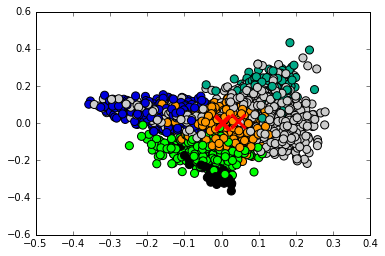

In [260]:
for n_clusters in range_n_clusters:
    y_kmeans = plot_y_kmeans[n_clusters]
    center = centers[n_clusters]
    print (len(y_kmeans))
    
    colors = cm.nipy_spectral(y_kmeans.astype(float) / n_clusters)
    plt.scatter(data2D[:,0], data2D[:,1], c =colors, s=65, cmap='viridis')
    plt.scatter(center[:, 0], center[:, 1], marker='x', s=200, linewidths=3, c='r')
    plt.show()
    break

In [21]:
print (dataset_df_matrix[5255])

[[0.         0.07423763 0.         ... 0.         0.         0.        ]]


In [42]:
## LSA Representation for clusterng LSA document vectors for 5 Dimensions
svd = TruncatedSVD(n_components=5, n_iter=7, random_state=20)
svd.fit(dataset_df_matrix)

TruncatedSVD(algorithm='randomized', n_components=5, n_iter=7,
       random_state=20, tol=0.0)

In [48]:
svd.components_

array([[ 0.03722104,  0.02056252,  0.00563141, ...,  0.02454992,
         0.01726253,  0.0179952 ],
       [ 0.13046728,  0.0028372 ,  0.00901429, ..., -0.02164096,
         0.01039501, -0.00426523],
       [-0.0223766 ,  0.00219029,  0.00267683, ...,  0.00685501,
        -0.00797941, -0.01262474],
       [-0.06876214, -0.01995934, -0.00315111, ...,  0.00239293,
        -0.01036977, -0.01047616],
       [-0.09792908, -0.01984282, -0.00152501, ...,  0.00835065,
         0.00595079,  0.02031189]])

In [49]:
## LSA Representation for clusterng LSA document vectors for 50 components
svd = TruncatedSVD(n_components=50, n_iter=7, random_state=20)
svd.fit(dataset_df_matrix)

TruncatedSVD(algorithm='randomized', n_components=50, n_iter=7,
       random_state=20, tol=0.0)

In [50]:
## LSA Representation for clusterng LSA document vectors for 100 components
svd = TruncatedSVD(n_components=100, n_iter=7, random_state=20)
svd.fit(dataset_df_matrix)

TruncatedSVD(algorithm='randomized', n_components=100, n_iter=7,
       random_state=20, tol=0.0)

In [51]:
## LSA Representation for clusterng LSA document vectors for 200 components
svd = TruncatedSVD(n_components=200, n_iter=7, random_state=20)
svd.fit(dataset_df_matrix)

TruncatedSVD(algorithm='randomized', n_components=200, n_iter=7,
       random_state=20, tol=0.0)

In [ ]:
# Author: Peter Prettenhofer <peter.prettenhofer@gmail.com>
#         Lars Buitinck
# License: BSD 3 clause



# Display progress logs on stdout
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')

# parse commandline arguments
op = OptionParser()
op.add_option("--lsa",
              dest="n_components", type="int",
              help="Preprocess documents with latent semantic analysis.")
op.add_option("--no-minibatch",
              action="store_false", dest="minibatch", default=True,
              help="Use ordinary k-means algorithm (in batch mode).")
op.add_option("--no-idf",
              action="store_false", dest="use_idf", default=True,
              help="Disable Inverse Document Frequency feature weighting.")
op.add_option("--use-hashing",
              action="store_true", default=False,
              help="Use a hashing feature vectorizer")
op.add_option("--n-features", type=int, default=10000,
              help="Maximum number of features (dimensions)"
                   " to extract from text.")
op.add_option("--verbose",
              action="store_true", dest="verbose", default=False,
              help="Print progress reports inside k-means algorithm.")

print(__doc__)
op.print_help()


def is_interactive():
    return not hasattr(sys.modules['__main__'], '__file__')


# work-around for Jupyter notebook and IPython console
argv = [] if is_interactive() else sys.argv[1:]
(opts, args) = op.parse_args(argv)
if len(args) > 0:
    op.error("this script takes no arguments.")
    sys.exit(1)


# #############################################################################
# Load some categories from the training set
categories = [
    'alt.atheism',
    'talk.religion.misc',
    'comp.graphics',
    'sci.space',
]
# Uncomment the following to do the analysis on all the categories
# categories = None

print("Loading 20 newsgroups dataset for categories:")
print(categories)

dataset = fetch_20newsgroups(subset='all', categories=categories,
                             shuffle=True, random_state=42)

print("%d documents" % len(dataset.data))
print("%d categories" % len(dataset.target_names))
print()

labels = dataset.target
true_k = np.unique(labels).shape[0]

print("Extracting features from the training dataset "
      "using a sparse vectorizer")
t0 = time()
if opts.use_hashing:
    if opts.use_idf:
        # Perform an IDF normalization on the output of HashingVectorizer
        hasher = HashingVectorizer(n_features=opts.n_features,
                                   stop_words='english', alternate_sign=False,
                                   norm=None, binary=False)
        vectorizer = make_pipeline(hasher, TfidfTransformer())
    else:
        vectorizer = HashingVectorizer(n_features=opts.n_features,
                                       stop_words='english',
                                       alternate_sign=False, norm='l2',
                                       binary=False)
else:
    vectorizer = TfidfVectorizer(max_df=0.5, max_features=opts.n_features,
                                 min_df=2, stop_words='english',
                                 use_idf=opts.use_idf)
X = vectorizer.fit_transform(dataset.data)

print("done in %fs" % (time() - t0))
print("n_samples: %d, n_features: %d" % X.shape)
print()

if opts.n_components:
    print("Performing dimensionality reduction using LSA")
    t0 = time()
    # Vectorizer results are normalized, which makes KMeans behave as
    # spherical k-means for better results. Since LSA/SVD results are
    # not normalized, we have to redo the normalization.
    svd = TruncatedSVD(opts.n_components)
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)

    X = lsa.fit_transform(X)

    print("done in %fs" % (time() - t0))

    explained_variance = svd.explained_variance_ratio_.sum()
    print("Explained variance of the SVD step: {}%".format(
        int(explained_variance * 100)))

    print()


# #############################################################################
# Do the actual clustering

if opts.minibatch:
    km = MiniBatchKMeans(n_clusters=true_k, init='k-means++', n_init=1,
                         init_size=1000, batch_size=1000, verbose=opts.verbose)
else:
    km = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1,
                verbose=opts.verbose)

print("Clustering sparse data with %s" % km)
t0 = time()
km.fit(X)
print("done in %0.3fs" % (time() - t0))
print()

print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labels, km.labels_))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, km.labels_, sample_size=1000))

print()


if not opts.use_hashing:
    print("Top terms per cluster:")

    if opts.n_components:
        original_space_centroids = svd.inverse_transform(km.cluster_centers_)
        order_centroids = original_space_centroids.argsort()[:, ::-1]
    else:
        order_centroids = km.cluster_centers_.argsort()[:, ::-1]

    terms = vectorizer.get_feature_names()
    for i in range(true_k):
        print("Cluster %d:" % i, end='')
        for ind in order_centroids[i, :10]:
            print(' %s' % terms[ind], end='')
        print()

In [74]:
import matplotlib.pyplot as plt
plt.plot([1,2,3,4])
plt.ylabel('some numbers')
plt.show()